In [1]:
# based on python code from Xenophon and Hill (2018) https://doi.org/10.1038/sdata.2018.203
# https://github.com/akxen/egrimod-nem

import os
import pickle

import geopandas as gp

import matplotlib.pyplot as plt
import shapely
from shapely.geometry import Point, Polygon

import pandas as pd
from shapely import wkt

In [2]:
# Polygons roughly describing NEM planning zones
# ----------------------------------------------
nem_z = {'NQ': [(137.996753, -22.590891),
                (147.600155, -22.69689),
                (149.488682, -21.82924),
                (149.488682, -10.153205),
                (137.996753, -10.153205),
                (137.996753, -22.590891)],
         'CQ': [(137.994396, -25.991606),
                (147.705872, -25.975166),
                (150.573035, -24.552175),
                (151.660193, -24.002144),
                (151.660193, -21.82924),
                (149.488682, -21.82924),
                (147.600155, -22.69689),
                (137.996753, -22.590891),
                (137.994396, -25.991606)],
         'SWQ': [(140.999053, -29.999342),
                 (152.345645, -28.999342),
                 (152.345175, -26.471211),
                 (150.573035, -24.552175),
                 (147.705872, -25.975166),
                 (137.994396, -25.991606),
                 (140.999053, -29.999342)],
         'NNS': [(140.988108, -30.625816),
                 (140.664089, -27.446275),
                 (154.281437, -27.511843),
                 (153.329201, -31.394614),
                 (152.919413, -31.403731),
                 (150.916062, -31.218307),
                 (143.686934, -31.026138),
                 (140.988108, -30.625816)],
         'NCEN': [(144.407274, -33.188936),
                  (147.10024, -33.703943),
                  (149.057623, -33.673314),
                  (150.7733, -35.104281),
                  (153.992359, -35.211407),
                  (154.277219, -31.394614),
                  (152.919413, -31.403731),
                  (150.916062, -31.218307),
                  (143.686934, -31.026138),
                  (140.988108, -30.625816),
                  (140.966342, -31.266686),
                  (144.407274, -33.188936)],
         'CAN': [(147.747047, -37.970467),
                 (151.271962, -37.970467),
                 (150.7733, -35.104281),
                 (149.057623, -33.673314),
                 (147.10024, -33.703943),
                 (147.747047, -34.279024),
                 (147.747047, -37.970467)],
         'NVIC': [(145.837530, -37.618056),
                  (150.111778, -37.594566),
                  (153.436856, -33.595619),
                  (144.716065, -33.595619),
                  (144.716065, -36.083442),
                  (145.517468, -37.182171),
                  (145.83753, -37.618056)],
         'LV': [(145.83753, -39.313587),
                  (150.111778, -39.313587),
                  (150.111778, -37.594566),
                  (145.83753, -37.618056),
                  (145.83753, -39.313587)],
         'MEL': [(140.84916, -39.403172),
                 (145.83753, -39.403172),
                 (145.83753, -37.618056),
                 (145.517468, -37.182171),
                 (140.969536, -37.666495),
                 (140.84916, -39.403172)],
         'SESA': [(137.455357, -38.575503),
                  (141.065187, -38.625711),
                  (140.99176, -35.135144),
                  (139.52216, -36.055673),
                  (137.455357, -38.575503)],
         'ADE': [(136.30871, -36.507665),
                 (139.52216, -36.055673),
                 (140.99176, -35.135144),
                 (140.995986, -34.582123),
                 (138.164567, -34.582123),
                 (137.914372, -35.22898),
                 (136.142608, -35.637815),
                 (136.30871, -36.507665)]}


In [3]:
# Transform NEM zone boundary coordinates to Polygon objects
nem_zone_poly = {y: Polygon(nem_z[y]) for y in nem_z.keys()}

# Data describing state and territory boundaries in Australia
gdf_states = gp.GeoDataFrame.from_file('input/1259030002_ste06aaust_shape/STE06aAUST.shp')
gdf_states.set_index('STATE_NAME', inplace=True)


In [4]:
# Defining state boundaries for NEM zones
# ---------------------------------------------------
# Basis NEM zones
# We use the following order throughout our paper: 'NSA', 'ADE', 'SESA', 'NQ', 'CQ', 'SWQ', 'SEQ', 'NNS', 
# 'NCEN', 'SWNSW', 'CAN', 'CVIC', 'NVIC', 'MEL', 'LV', 'TAS'

bz = {'NSA': {'states': ['South Australia']},
      'ADE': {'states': ['South Australia']},
      'SESA': {'states': ['South Australia']},
      'NQ': {'states': ['Queensland']},
      'CQ': {'states': ['Queensland']},
      'SWQ': {'states': ['Queensland']},
      'SEQ': {'states': ['Queensland']},
      'NNS': {'states': ['New South Wales']},
      'NCEN': {'states': ['New South Wales']},
      'SWNSW': {'states': ['New South Wales']},
      'CAN': {'states': ['New South Wales', 'Australian Capital Territory']},
      'CVIC': {'states': ['Victoria']},
      'NVIC': {'states': ['Victoria']},
      'MEL': {'states': ['Victoria']},
      'LV': {'states': ['Victoria']},
      'TAS': {'states': ['Tasmania']}
      }

In [5]:
# For each rough sketch of a NEM zone polygon (in nem_z), compute the
# difference between the rough sketch and state boundary in which the
# NEM zone resides. This yields a more 'polished' NEM zone polygon.
for z in bz.keys():
    # Check if a polygon has been defined for this NEM zone
    if z in nem_z.keys():
        # State boundary for region (sometimes aggregated e.g. ACT and NSW)
        state_poly = shapely.ops.cascaded_union([gdf_states.loc[i, 'geometry'] for i in bz[z]['states']])

        # Rough sketch describing NEM zone
        poly = nem_zone_poly[z]

        # Intersection of state boundary and NEM zone sketch
        poly_sec = poly.intersection(state_poly)

        # Add 'polished' NEM zone boundary to original dictionary
        bz[z]['geometry'] = poly_sec

# Construct remaining zones from basis zones (using polygon differencing)
bz['SEQ']['geometry'] = gdf_states.loc['Queensland', 'geometry'].difference(shapely.ops.cascaded_union([bz[z]['geometry'] for z in ['NQ','CQ','SWQ']]))
bz['SWNSW']['geometry'] = gdf_states.loc['New South Wales', 'geometry'].difference(shapely.ops.cascaded_union([bz[z]['geometry'] for z in ['NNS','NCEN','CAN']]))
bz['CVIC']['geometry'] = gdf_states.loc['Victoria', 'geometry'].difference(shapely.ops.cascaded_union([bz[z]['geometry'] for z in ['NVIC','LV','MEL']]))
bz['NSA']['geometry'] = gdf_states.loc['South Australia', 'geometry'].difference(shapely.ops.cascaded_union([bz[z]['geometry'] for z in ['SESA','ADE']]))
bz['TAS']['geometry'] = gdf_states.loc['Tasmania', 'geometry']

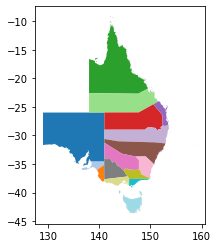

In [6]:
# Construct geodataframe
gdf_nem_zones = gp.GeoDataFrame(data=bz)
gdf_nem_zones = gdf_nem_zones.T
gdf_nem_zones = gdf_nem_zones.set_crs(gdf_states.crs)

with open('gdf_nem_zones.pickle', 'wb') as f:
    pickle.dump(gdf_nem_zones, f)
    
# Plot NEM zones
ax = gdf_nem_zones.plot(cmap='tab20')
plt.show()

/usr/lib/python3/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


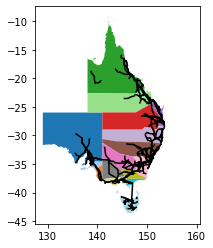

In [7]:
# plot transmission lines
with open('input/gdf_l.pickle', 'rb') as f:
    gdf_l = pickle.load(f)
gdf_l = gdf_l.set_crs(gdf_states.crs)
ax_zone_line=gdf_l.plot(markersize=0.1, edgecolor='k', ax=gdf_nem_zones.plot(cmap='tab20'))

<Figure size 1080x1080 with 0 Axes>

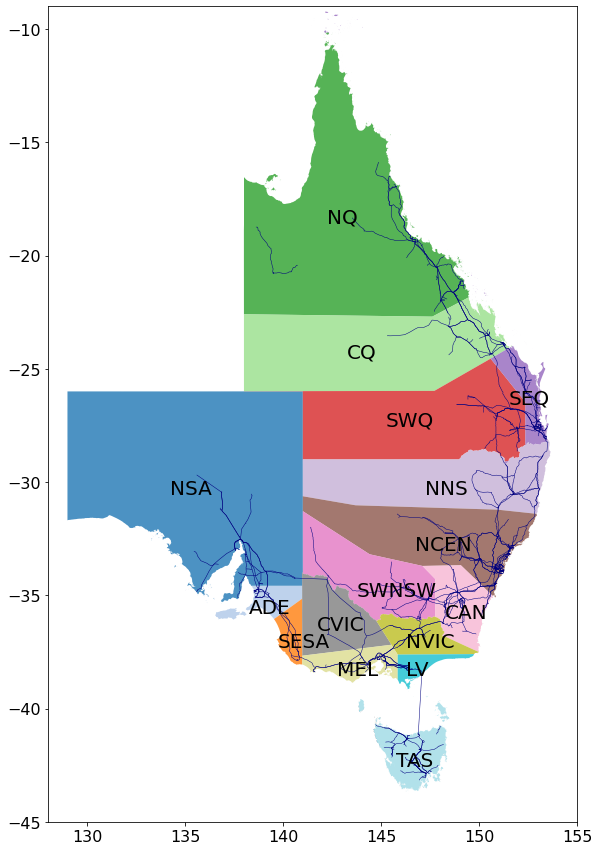

In [9]:
# add zone labels

df_sample_coords=pd.read_csv(os.path.join(os.getcwd(),'../NEM_zone_sampling_coords_center.csv'), index_col='name')
df_sample_coords['coordinates']='POINT(' + df_sample_coords['lon'].map(str) +' '+ df_sample_coords['lat'].map(str) +')'
df_sample_coords['coordinates'] = df_sample_coords['coordinates'].apply(wkt.loads)
gdf_coords = gp.GeoDataFrame(df_sample_coords, geometry='coordinates')
gdf_coords=gdf_coords.set_crs(gdf_states.crs)



n=15
fig = plt.figure(figsize=(n, n))
ax=gdf_coords.plot( marker=' ', color='k', markersize=50, ax=gdf_l.plot(linewidth=0.5, edgecolor='navy', ax=gdf_nem_zones.plot(cmap='tab20', alpha=0.8, figsize=(n,n))))
for x, y, label in zip(gdf_coords.geometry.x, gdf_coords.geometry.y, gdf_coords.index):
    ax.annotate(label, xy=(x, y), xytext=(-15, -12), textcoords="offset points", fontsize=20)
plt.xlim(128,155)
plt.ylim(-45, -9)
#plt.xlabel('long', size=16)
#plt.ylabel('lat', size=16)
plt.xticks(size=16)
plt.yticks(size=16)

plt.savefig('nem_map.png', dpi=300)
plt.show()

<Figure size 1080x1080 with 0 Axes>

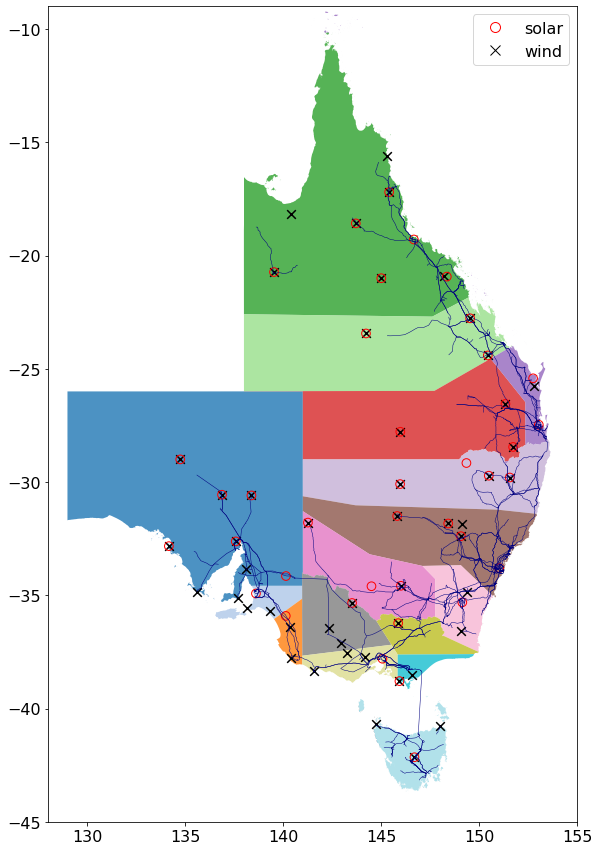

In [14]:
# add sample points

#pv
df_pv_coords=pd.read_csv(os.path.join(os.getcwd(),'../NEM_zone_sampling_coords_pv.csv'), index_col='name')
df_pv_coords['coordinates']='POINT(' + df_pv_coords['lon'].map(str) +' '+ df_pv_coords['lat'].map(str) +')'
df_pv_coords['coordinates'] = df_pv_coords['coordinates'].apply(wkt.loads)
gdf_pv_coords = gp.GeoDataFrame(df_pv_coords, geometry='coordinates')
gdf_pv_coords=gdf_pv_coords.set_crs(gdf_states.crs)

# wind
df_wind_coords=pd.read_csv(os.path.join(os.getcwd(),'../NEM_zone_sampling_coords_wind.csv'), index_col='name')
df_wind_coords['coordinates']='POINT(' + df_wind_coords['lon'].map(str) +' '+ df_wind_coords['lat'].map(str) +')'
df_wind_coords['coordinates'] = df_wind_coords['coordinates'].apply(wkt.loads)
gdf_wind_coords = gp.GeoDataFrame(df_wind_coords, geometry='coordinates')
gdf_wind_coords=gdf_wind_coords.set_crs(gdf_states.crs)




n=15
fig = plt.figure(figsize=(n, n))
ax=gdf_coords.plot( marker=' ', 
    ax=gdf_pv_coords.plot( marker='o', color="none", edgecolor="red" , markersize=75, 
        ax=gdf_wind_coords.plot( marker='x', color='k', markersize=75, 
            ax=gdf_l.plot(linewidth=0.5, edgecolor='navy', 
                ax=gdf_nem_zones.plot(cmap='tab20', alpha=0.8, figsize=(n,n))
                         )
                               )
                        )
    )

# for x, y, label in zip(gdf_coords.geometry.x, gdf_coords.geometry.y, gdf_coords.index):
#    ax.annotate(label, xy=(x, y), xytext=(-15, -12), textcoords="offset points", fontsize=20)
    
plt.xlim(128,155)
plt.ylim(-45, -9)
#plt.xlabel('lon', size=16)
#plt.ylabel('lat', size=16)
plt.xticks(size=16)
plt.yticks(size=16)



# make legend

from matplotlib.lines import Line2D
red_circle= Line2D([], [], marker='o', color='r', label='solar', lw=0,
                          markerfacecolor='w', markersize=10)
black_x=Line2D([], [], color='k' , marker='x', linestyle='None',
                          markersize=10, label='wind')
plt.legend(handles=[red_circle, black_x], prop={'size':16})


plt.savefig('nem_map_pv_wind_sampling.png', dpi=300)
plt.show()